# U-net - Example application

*Marcos R. A. Conceição*

## The U-net architechure

A U-net is a state-of-art fully convolutional neural network (FCNN) first described by Ronneberger *et al.* (2015). Such network is based on three major pillars: encoder-decoder structure, multi-scale analysis and skip-connections. A typical U-net gets high-resolution $N$-dimensional tensor data as input (i.e., time series, images and volumes), which suffers multiple filtering by a number of trainable convolutional kernels, applied to an activation function and reduced on its dimensions for a posterior lower resolution processing. This sequence is applied, scale after scale, down to the last one. Such process is called the encoding, as the lower resolution layers hold condensed representations of abstract features present in the original data. Such condition is forced during trained, once such low resolution representations need to be decompressed by the network on later decoding steps. Each of such steps resizes inputs to the resolution used on the upper scale and performs other number of similar filtering operations. A key improvement used in U-nets are the so called skip connections. At each scale, before filtering the decompressed data, they are concatenated with the last outputs gotten for the same scale, back in the compression stage. This simple addition gets previously available higher resolution data features to be recalled by the network, making U-net results remarkably precise when locating events, when compared to other networks (even when it comes to common FCNNs). The last step in this model is the application of $M$ convolutional filters to the outputs --- now in the original scale --- which are going to produce $M$ outputs on each data dimension. These outputs may represent probability of belonging to each of the $M$ considered classes when segmentation is the task, or even the $M$ different channels of output image.

## Example problem

Here we will use a U-net over mnist dataset to perform segmentation of zeros in input image.

## Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks

import sklearn.datasets as skds
from sklearn.model_selection import train_test_split

from unet import make_unet

## Setting up the data

In [3]:
X, y = skds.load_digits(n_class=10, return_X_y=True)
X = X.reshape(-1, 8, 8, 1)

In [4]:
X_mean = X.mean(axis=(1,2,3))[:,None,None,None]
X_std = X.std(axis=(1,2,3))[:,None,None,None]
X_norm = (X-X_mean)/X_std
thresh = .5
Y = X_norm >= thresh

In [5]:
num_masked = 0
Y_num = Y * (y==num_masked)[:, None, None, None]
del(X_mean)
del(X_std)
del(X_norm)

In [6]:
X_true = X
Y_true = Y_num

## Balancing dataset

In [7]:
idx_masked, = np.nonzero(y==num_masked)
idx_not_masked, = np.nonzero(y!=num_masked)

idx_masked.size / y.size

0.09905397885364496

In [8]:
idx_balance = np.concatenate([idx_masked, idx_not_masked[:idx_masked.size]])
np.random.shuffle(idx_balance)

X_true = X_true[idx_balance]
Y_true = Y_true[idx_balance]

## Showing data

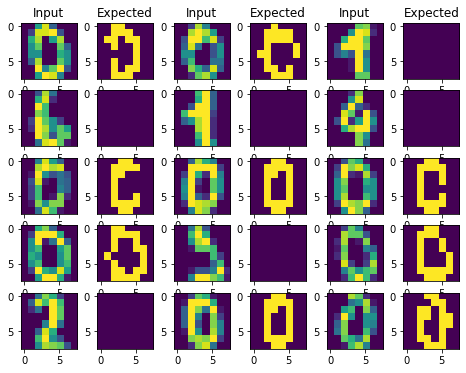

In [9]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 2*ncols, figsize=(8, 6))
for j in range(0, axes.shape[1], 2):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

## Defining U-net

In [20]:
model = make_unet(
    X.shape[1:],
    nout=1,
    scales=2,
    nconvs_by_scale=2,
    base_filters=3,
    kernel_size=3,
    activation='relu',
    first_activation='tanh',
    last_activation='sigmoid',
    interpolator='bilinear',
    last_interpolator=None,
    norm=True,
    dropout=False,
    norm_at_start=True,
    nconvs_bottom=None,
    use_skip_connections=True,
    return_encoders=False,
    verbose=True,
)

start    (None, 8, 8, 1)
prepare  (None, 8, 8, 3)
downward (None, 4, 4, 6)
downward (None, 2, 2, 12)
upward   (None, 4, 4, 6)
upward   (None, 8, 8, 3)
out      (None, 8, 8, 1)


## U-net predictions - before training

/home/marcosrdac/.local/share/python_envs/m/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


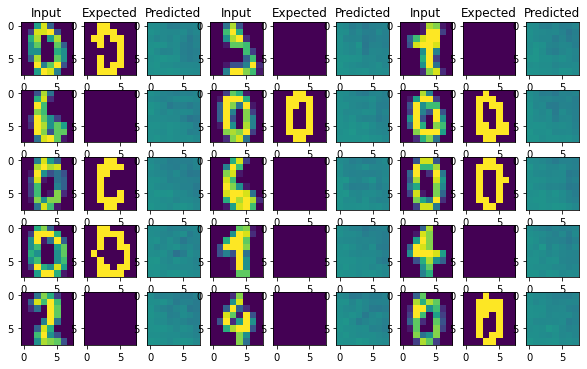

In [21]:
Y_pred_proba = model.predict(X)

i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred_proba[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

## Preparing holdout validation

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_true,
                                                    Y_true,
                                                    test_size=1 / 4)
print('n_train: {X_train.shape[0]}')
print('n_test:  {X_test.shape[0]}\n')

n_train: {X_train.shape[0]}
n_test:  {X_test.shape[0]}



## Training U-net

In [23]:
learning_rate = 0.0005
max_epochs = 2000
batch_size = X_train.shape[0]
# batch_size = 100

optim = optimizers.Adam(learning_rate)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

callback_list = [
    callbacks.EarlyStopping(
        mode='min',
        monitor='val_loss',
        patience=80,
        min_delta=0,
        verbose=1,
        baseline=None,
        restore_best_weights=True,
    )
]

train = model.fit(X_train,
                  Y_train,
                  epochs=max_epochs,
                  validation_data=(X_test, Y_test),
                  callbacks=callback_list,
                  batch_size=batch_size)

Epoch 1/2000
1/1 [==============================] - 0s 349ms/step - loss: 0.8827 - accuracy: 0.4099 - val_loss: 0.6550 - val_accuracy: 0.6987
Epoch 2/2000
1/1 [==============================] - 0s 206ms/step - loss: 0.8569 - accuracy: 0.4265 - val_loss: 0.6544 - val_accuracy: 0.6986
Epoch 3/2000
1/1 [==============================] - 0s 225ms/step - loss: 0.8336 - accuracy: 0.4400 - val_loss: 0.6537 - val_accuracy: 0.6979
Epoch 4/2000
1/1 [==============================] - 0s 262ms/step - loss: 0.8135 - accuracy: 0.4550 - val_loss: 0.6529 - val_accuracy: 0.6979
Epoch 5/2000
1/1 [==============================] - 0s 226ms/step - loss: 0.7962 - accuracy: 0.4642 - val_loss: 0.6520 - val_accuracy: 0.6950
Epoch 6/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.7816 - accuracy: 0.4747 - val_loss: 0.6511 - val_accuracy: 0.6952
Epoch 7/2000
1/1 [==============================] - 0s 244ms/step - loss: 0.7685 - accuracy: 0.4834 - val_loss: 0.6502 - val_accuracy: 0.6936
Epoch 

1/1 [==============================] - 0s 220ms/step - loss: 0.3861 - accuracy: 0.8504 - val_loss: 0.5556 - val_accuracy: 0.8002
Epoch 116/2000
1/1 [==============================] - 0s 214ms/step - loss: 0.3845 - accuracy: 0.8515 - val_loss: 0.5531 - val_accuracy: 0.8016
Epoch 117/2000
1/1 [==============================] - 0s 265ms/step - loss: 0.3830 - accuracy: 0.8530 - val_loss: 0.5507 - val_accuracy: 0.8028
Epoch 118/2000
1/1 [==============================] - 0s 220ms/step - loss: 0.3814 - accuracy: 0.8539 - val_loss: 0.5482 - val_accuracy: 0.8060
Epoch 119/2000
1/1 [==============================] - 0s 189ms/step - loss: 0.3799 - accuracy: 0.8549 - val_loss: 0.5458 - val_accuracy: 0.8072
Epoch 120/2000
1/1 [==============================] - 0s 304ms/step - loss: 0.3783 - accuracy: 0.8562 - val_loss: 0.5435 - val_accuracy: 0.8092
Epoch 121/2000
1/1 [==============================] - 0s 201ms/step - loss: 0.3768 - accuracy: 0.8577 - val_loss: 0.5412 - val_accuracy: 0.8114
Epoch 1

Epoch 172/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.3126 - accuracy: 0.9119 - val_loss: 0.4792 - val_accuracy: 0.8588
Epoch 173/2000
1/1 [==============================] - 0s 284ms/step - loss: 0.3114 - accuracy: 0.9125 - val_loss: 0.4783 - val_accuracy: 0.8597
Epoch 174/2000
1/1 [==============================] - 0s 208ms/step - loss: 0.3103 - accuracy: 0.9131 - val_loss: 0.4773 - val_accuracy: 0.8610
Epoch 175/2000
1/1 [==============================] - 0s 289ms/step - loss: 0.3092 - accuracy: 0.9138 - val_loss: 0.4763 - val_accuracy: 0.8624
Epoch 176/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.3081 - accuracy: 0.9143 - val_loss: 0.4753 - val_accuracy: 0.8625
Epoch 177/2000
1/1 [==============================] - 0s 211ms/step - loss: 0.3070 - accuracy: 0.9149 - val_loss: 0.4743 - val_accuracy: 0.8624
Epoch 178/2000
1/1 [==============================] - 0s 243ms/step - loss: 0.3059 - accuracy: 0.9154 - val_loss: 0.4733 - val_accuracy:

Epoch 229/2000
1/1 [==============================] - 0s 212ms/step - loss: 0.2550 - accuracy: 0.9404 - val_loss: 0.4102 - val_accuracy: 0.8973
Epoch 230/2000
1/1 [==============================] - 0s 279ms/step - loss: 0.2540 - accuracy: 0.9408 - val_loss: 0.4091 - val_accuracy: 0.8978
Epoch 231/2000
1/1 [==============================] - 0s 276ms/step - loss: 0.2531 - accuracy: 0.9412 - val_loss: 0.4080 - val_accuracy: 0.8987
Epoch 232/2000
1/1 [==============================] - 0s 200ms/step - loss: 0.2522 - accuracy: 0.9418 - val_loss: 0.4069 - val_accuracy: 0.8992
Epoch 233/2000
1/1 [==============================] - 0s 258ms/step - loss: 0.2513 - accuracy: 0.9428 - val_loss: 0.4058 - val_accuracy: 0.8998
Epoch 234/2000
1/1 [==============================] - 0s 316ms/step - loss: 0.2504 - accuracy: 0.9429 - val_loss: 0.4047 - val_accuracy: 0.9006
Epoch 235/2000
1/1 [==============================] - 0s 185ms/step - loss: 0.2495 - accuracy: 0.9433 - val_loss: 0.4035 - val_accuracy:

Epoch 286/2000
1/1 [==============================] - 0s 206ms/step - loss: 0.2051 - accuracy: 0.9651 - val_loss: 0.3471 - val_accuracy: 0.9256
Epoch 287/2000
1/1 [==============================] - 0s 183ms/step - loss: 0.2043 - accuracy: 0.9654 - val_loss: 0.3460 - val_accuracy: 0.9256
Epoch 288/2000
1/1 [==============================] - 0s 293ms/step - loss: 0.2035 - accuracy: 0.9655 - val_loss: 0.3451 - val_accuracy: 0.9263
Epoch 289/2000
1/1 [==============================] - 0s 212ms/step - loss: 0.2027 - accuracy: 0.9659 - val_loss: 0.3441 - val_accuracy: 0.9268
Epoch 290/2000
1/1 [==============================] - 0s 259ms/step - loss: 0.2019 - accuracy: 0.9661 - val_loss: 0.3432 - val_accuracy: 0.9271
Epoch 291/2000
1/1 [==============================] - 0s 258ms/step - loss: 0.2011 - accuracy: 0.9668 - val_loss: 0.3423 - val_accuracy: 0.9273
Epoch 292/2000
1/1 [==============================] - 0s 227ms/step - loss: 0.2004 - accuracy: 0.9669 - val_loss: 0.3414 - val_accuracy:

Epoch 343/2000
1/1 [==============================] - 0s 181ms/step - loss: 0.1650 - accuracy: 0.9745 - val_loss: 0.2792 - val_accuracy: 0.9415
Epoch 344/2000
1/1 [==============================] - 0s 151ms/step - loss: 0.1643 - accuracy: 0.9745 - val_loss: 0.2780 - val_accuracy: 0.9419
Epoch 345/2000
1/1 [==============================] - 0s 189ms/step - loss: 0.1637 - accuracy: 0.9744 - val_loss: 0.2766 - val_accuracy: 0.9421
Epoch 346/2000
1/1 [==============================] - 0s 176ms/step - loss: 0.1630 - accuracy: 0.9747 - val_loss: 0.2755 - val_accuracy: 0.9419
Epoch 347/2000
1/1 [==============================] - 0s 180ms/step - loss: 0.1624 - accuracy: 0.9745 - val_loss: 0.2742 - val_accuracy: 0.9422
Epoch 348/2000
1/1 [==============================] - 0s 196ms/step - loss: 0.1617 - accuracy: 0.9748 - val_loss: 0.2729 - val_accuracy: 0.9422
Epoch 349/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.1611 - accuracy: 0.9750 - val_loss: 0.2717 - val_accuracy:

Epoch 400/2000
1/1 [==============================] - 0s 254ms/step - loss: 0.1339 - accuracy: 0.9796 - val_loss: 0.2175 - val_accuracy: 0.9517
Epoch 401/2000
1/1 [==============================] - 0s 263ms/step - loss: 0.1335 - accuracy: 0.9795 - val_loss: 0.2168 - val_accuracy: 0.9515
Epoch 402/2000
1/1 [==============================] - 0s 263ms/step - loss: 0.1330 - accuracy: 0.9798 - val_loss: 0.2155 - val_accuracy: 0.9526
Epoch 403/2000
1/1 [==============================] - 0s 269ms/step - loss: 0.1326 - accuracy: 0.9794 - val_loss: 0.2148 - val_accuracy: 0.9526
Epoch 404/2000
1/1 [==============================] - 0s 279ms/step - loss: 0.1322 - accuracy: 0.9799 - val_loss: 0.2139 - val_accuracy: 0.9522
Epoch 405/2000
1/1 [==============================] - 0s 239ms/step - loss: 0.1317 - accuracy: 0.9796 - val_loss: 0.2133 - val_accuracy: 0.9524
Epoch 406/2000
1/1 [==============================] - 0s 181ms/step - loss: 0.1313 - accuracy: 0.9798 - val_loss: 0.2124 - val_accuracy:

Epoch 457/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.1120 - accuracy: 0.9826 - val_loss: 0.1761 - val_accuracy: 0.9621
Epoch 458/2000
1/1 [==============================] - 0s 225ms/step - loss: 0.1117 - accuracy: 0.9824 - val_loss: 0.1758 - val_accuracy: 0.9617
Epoch 459/2000
1/1 [==============================] - 0s 270ms/step - loss: 0.1113 - accuracy: 0.9826 - val_loss: 0.1749 - val_accuracy: 0.9626
Epoch 460/2000
1/1 [==============================] - 0s 293ms/step - loss: 0.1110 - accuracy: 0.9827 - val_loss: 0.1740 - val_accuracy: 0.9628
Epoch 461/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.1107 - accuracy: 0.9827 - val_loss: 0.1742 - val_accuracy: 0.9623
Epoch 462/2000
1/1 [==============================] - 0s 236ms/step - loss: 0.1104 - accuracy: 0.9830 - val_loss: 0.1728 - val_accuracy: 0.9633
Epoch 463/2000
1/1 [==============================] - 0s 230ms/step - loss: 0.1101 - accuracy: 0.9830 - val_loss: 0.1735 - val_accuracy:

Epoch 514/2000
1/1 [==============================] - 0s 191ms/step - loss: 0.0952 - accuracy: 0.9858 - val_loss: 0.1494 - val_accuracy: 0.9666
Epoch 515/2000
1/1 [==============================] - 0s 250ms/step - loss: 0.0950 - accuracy: 0.9857 - val_loss: 0.1479 - val_accuracy: 0.9673
Epoch 516/2000
1/1 [==============================] - 0s 234ms/step - loss: 0.0948 - accuracy: 0.9853 - val_loss: 0.1487 - val_accuracy: 0.9666
Epoch 517/2000
1/1 [==============================] - 0s 230ms/step - loss: 0.0946 - accuracy: 0.9858 - val_loss: 0.1470 - val_accuracy: 0.9670
Epoch 518/2000
1/1 [==============================] - 0s 255ms/step - loss: 0.0944 - accuracy: 0.9853 - val_loss: 0.1478 - val_accuracy: 0.9670
Epoch 519/2000
1/1 [==============================] - 0s 227ms/step - loss: 0.0940 - accuracy: 0.9861 - val_loss: 0.1470 - val_accuracy: 0.9673
Epoch 520/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.0937 - accuracy: 0.9858 - val_loss: 0.1467 - val_accuracy:

Epoch 627/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0713 - accuracy: 0.9903 - val_loss: 0.1180 - val_accuracy: 0.9703
Epoch 628/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0712 - accuracy: 0.9900 - val_loss: 0.1179 - val_accuracy: 0.9700
Epoch 629/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.0708 - accuracy: 0.9904 - val_loss: 0.1171 - val_accuracy: 0.9705
Epoch 630/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0706 - accuracy: 0.9904 - val_loss: 0.1172 - val_accuracy: 0.9703
Epoch 631/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.0704 - accuracy: 0.9905 - val_loss: 0.1180 - val_accuracy: 0.9700
Epoch 632/2000
1/1 [==============================] - 0s 133ms/step - loss: 0.0703 - accuracy: 0.9905 - val_loss: 0.1166 - val_accuracy: 0.9707
Epoch 633/2000
1/1 [==============================] - 0s 141ms/step - loss: 0.0702 - accuracy: 0.9904 - val_loss: 0.1168 - val_accuracy:

Epoch 684/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0623 - accuracy: 0.9917 - val_loss: 0.1070 - val_accuracy: 0.9703
Epoch 685/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0622 - accuracy: 0.9923 - val_loss: 0.1062 - val_accuracy: 0.9710
Epoch 686/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0621 - accuracy: 0.9919 - val_loss: 0.1065 - val_accuracy: 0.9717
Epoch 687/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0618 - accuracy: 0.9923 - val_loss: 0.1066 - val_accuracy: 0.9707
Epoch 688/2000
1/1 [==============================] - 0s 162ms/step - loss: 0.0615 - accuracy: 0.9923 - val_loss: 0.1060 - val_accuracy: 0.9709
Epoch 689/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0613 - accuracy: 0.9924 - val_loss: 0.1062 - val_accuracy: 0.9721
Epoch 690/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0613 - accuracy: 0.9925 - val_loss: 0.1061 - val_accuracy:

Epoch 741/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0545 - accuracy: 0.9937 - val_loss: 0.0997 - val_accuracy: 0.9716
Epoch 742/2000
1/1 [==============================] - 0s 212ms/step - loss: 0.0544 - accuracy: 0.9936 - val_loss: 0.1000 - val_accuracy: 0.9716
Epoch 743/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0542 - accuracy: 0.9936 - val_loss: 0.0996 - val_accuracy: 0.9724
Epoch 744/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0540 - accuracy: 0.9939 - val_loss: 0.0994 - val_accuracy: 0.9724
Epoch 745/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0539 - accuracy: 0.9937 - val_loss: 0.0994 - val_accuracy: 0.9717
Epoch 746/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0539 - accuracy: 0.9937 - val_loss: 0.0988 - val_accuracy: 0.9723
Epoch 747/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0538 - accuracy: 0.9937 - val_loss: 0.0991 - val_accuracy:

Epoch 798/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0481 - accuracy: 0.9944 - val_loss: 0.0923 - val_accuracy: 0.9744
Epoch 799/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0481 - accuracy: 0.9945 - val_loss: 0.0931 - val_accuracy: 0.9733
Epoch 800/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0480 - accuracy: 0.9946 - val_loss: 0.0926 - val_accuracy: 0.9744
Epoch 801/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0478 - accuracy: 0.9945 - val_loss: 0.0925 - val_accuracy: 0.9742
Epoch 802/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0478 - accuracy: 0.9947 - val_loss: 0.0928 - val_accuracy: 0.9738
Epoch 803/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0476 - accuracy: 0.9947 - val_loss: 0.0929 - val_accuracy: 0.9740
Epoch 804/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0475 - accuracy: 0.9947 - val_loss: 0.0928 - val_accuracy:

Epoch 855/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0428 - accuracy: 0.9954 - val_loss: 0.0899 - val_accuracy: 0.9742
Epoch 856/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0427 - accuracy: 0.9956 - val_loss: 0.0898 - val_accuracy: 0.9742
Epoch 857/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0427 - accuracy: 0.9955 - val_loss: 0.0896 - val_accuracy: 0.9747
Epoch 858/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0427 - accuracy: 0.9956 - val_loss: 0.0907 - val_accuracy: 0.9738
Epoch 859/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0426 - accuracy: 0.9957 - val_loss: 0.0892 - val_accuracy: 0.9745
Epoch 860/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0424 - accuracy: 0.9958 - val_loss: 0.0895 - val_accuracy: 0.9747
Epoch 861/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0423 - accuracy: 0.9958 - val_loss: 0.0904 - val_accuracy:

Epoch 912/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0383 - accuracy: 0.9966 - val_loss: 0.0888 - val_accuracy: 0.9749
Epoch 913/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0384 - accuracy: 0.9964 - val_loss: 0.0901 - val_accuracy: 0.9738
Epoch 914/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0384 - accuracy: 0.9964 - val_loss: 0.0890 - val_accuracy: 0.9751
Epoch 915/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0386 - accuracy: 0.9963 - val_loss: 0.0895 - val_accuracy: 0.9745
Epoch 916/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0384 - accuracy: 0.9963 - val_loss: 0.0889 - val_accuracy: 0.9749
Epoch 917/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0382 - accuracy: 0.9967 - val_loss: 0.0893 - val_accuracy: 0.9745
Epoch 918/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0378 - accuracy: 0.9967 - val_loss: 0.0891 - val_accuracy:

Epoch 969/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0343 - accuracy: 0.9974 - val_loss: 0.0883 - val_accuracy: 0.9742
Epoch 970/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0343 - accuracy: 0.9974 - val_loss: 0.0875 - val_accuracy: 0.9742
Epoch 971/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0343 - accuracy: 0.9973 - val_loss: 0.0882 - val_accuracy: 0.9742
Epoch 972/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0342 - accuracy: 0.9975 - val_loss: 0.0878 - val_accuracy: 0.9744
Epoch 973/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0341 - accuracy: 0.9975 - val_loss: 0.0880 - val_accuracy: 0.9742
Epoch 974/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0340 - accuracy: 0.9975 - val_loss: 0.0876 - val_accuracy: 0.9745
Epoch 975/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0339 - accuracy: 0.9975 - val_loss: 0.0882 - val_accuracy:

Epoch 1026/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0311 - accuracy: 0.9976 - val_loss: 0.0872 - val_accuracy: 0.9740
Epoch 1027/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0310 - accuracy: 0.9979 - val_loss: 0.0874 - val_accuracy: 0.9744
Epoch 1028/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0309 - accuracy: 0.9975 - val_loss: 0.0873 - val_accuracy: 0.9745
Epoch 1029/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0309 - accuracy: 0.9978 - val_loss: 0.0875 - val_accuracy: 0.9740
Epoch 1030/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0308 - accuracy: 0.9978 - val_loss: 0.0870 - val_accuracy: 0.9738
Epoch 1031/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0307 - accuracy: 0.9980 - val_loss: 0.0879 - val_accuracy: 0.9738
Epoch 1032/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0307 - accuracy: 0.9978 - val_loss: 0.0863 - val_ac

## Showing history

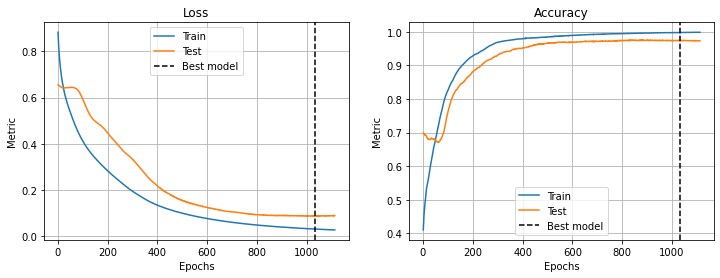

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = 1 + np.arange(len(train.history['loss']))

axes[0].set_title('Loss')
axes[0].plot(epochs, train.history['loss'], label='Train')
axes[0].plot(epochs, train.history['val_loss'], label='Test')
# axes[0].set_yscale('log')

axes[1].set_title('Accuracy')
axes[1].plot(epochs, train.history['accuracy'], label='Train')
axes[1].plot(epochs, train.history['val_accuracy'], label='Test')

for ax in axes:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metric')
    ax.grid()
    ax.axvline(
        epochs[np.argmin(train.history['val_loss'])],
        label='Best model',
        c='k',
        ls='--',
    )
    ax.legend()
plt.show()

## U-net predictions - after training

In [25]:
Y_pred_proba = model.predict(X_true)
Y_pred = Y_pred_proba >= .5

/home/marcosrdac/.local/share/python_envs/m/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


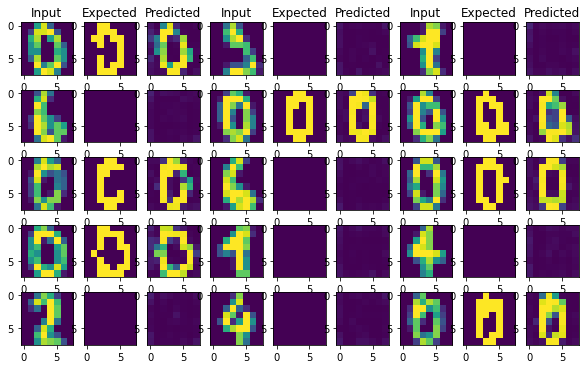

In [26]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred_proba[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

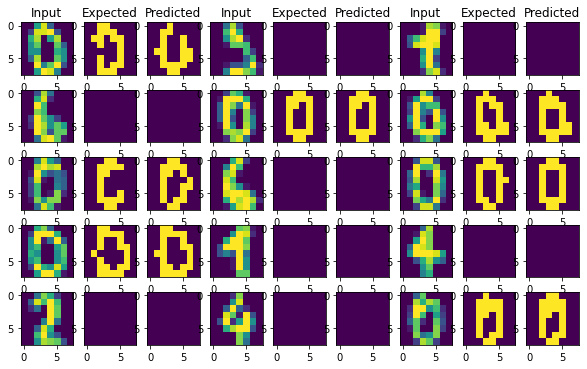

In [27]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()